In [ ]:
# Environment setup function
def setup_spark_environment():
    # Install dependencies
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    !wget -q https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
    !tar xf spark-3.5.4-bin-hadoop3.tgz
    !pip install -q findspark

    # Set environment variables
    import os
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

    # Initialize findspark
    import findspark
    findspark.init()

    # Create Spark session
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.appName("GoldPricePrediction").getOrCreate()

    return spark

# Call setup function
spark = setup_spark_environment()

#Task 3

##Library

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, udf
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors as MLVectors, VectorUDT
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors as MLLibVectors
import matplotlib.pyplot as plt
import numpy as np
import random
import time

##CUR Class

In [ ]:
random.seed(42)
class CUR_Decomposition:
    """
    Class implementing CUR decomposition for dimensionality reduction.
    C: Selected columns from original matrix
    U: Connecting matrix
    R: Selected rows from original matrix
    """

    def __init__(self, target_dim=5, seed=42):
        """
        Initialize CUR decomposition.

        Parameters:
        -----------
        target_dim : int
            Target dimensionality after reduction
        seed : int
            Random seed for reproducibility
        """
        self.target_dim = target_dim
        self.seed = seed
        self.column_indices = None
        self.column_probabilities = None
        self.row_indices = None
        self.U_matrix = None
        random.seed(seed)
        np.random.seed(seed)

    def fit(self, data, features_col="features"):
        """
        Fit the CUR decomposition.

        Parameters:
        -----------
        data : DataFrame
            Spark DataFrame with feature column
        features_col : str
            Name of the column containing feature vectors

        Returns:
        --------
        self
        """
        #Step 1: Convert to RDD of vectors for RowMatrix
        start_time = time.time()

        #Extract vectors from dataframe to RDD
        vector_rdd = data.select(features_col).rdd.map(lambda row: MLLibVectors.fromML(row[0]))

        #Create a RowMatrix
        mat = RowMatrix(vector_rdd)

        #Get dimensions
        m = mat.numRows()
        n = mat.numCols()

        print(f"Matrix dimensions: {m} rows x {n} columns")

        #Step 2: Compute SVD to get leverage scores
        svd = mat.computeSVD(n, computeU=True)
        s = svd.s
        V = svd.V

        print(f"SVD computation time: {time.time() - start_time:.2f} seconds")

        #Step 3: Calculate column probabilities (leverage scores)
        #For columns: Leverage scores based on right singular vectors
        squared_V = np.square(V.toArray())
        col_leverage = np.sum(squared_V, axis=0)
        col_probs = col_leverage / np.sum(col_leverage)

        #Step 4: Sample columns according to their probabilities
        self.column_indices = np.random.choice(
            n, size=self.target_dim, replace=False, p=col_probs
        )
        self.column_indices = sorted(self.column_indices)
        self.column_probabilities = col_probs[self.column_indices]

        print(f"Selected columns: {self.column_indices}")
        print(f"With probabilities: {self.column_probabilities}")

        return self

    def transform(self, data, features_col="features"):
        """
        Transform data using CUR decomposition.

        Parameters:
        -----------
        data : DataFrame
            DataFrame to transform
        features_col : str
            Name of the column containing feature vectors

        Returns:
        --------
        DataFrame
            DataFrame with reduced features
        """
        if self.column_indices is None:
            raise ValueError("CUR decomposition not fitted yet.")

        #Create UDF to extract selected columns from feature vector
        @udf(returnType=VectorUDT())
        def extract_columns(vector):
            if vector is None:
                return None

            features = vector.toArray()
            selected_features = [features[idx] for idx in self.column_indices]
            return MLVectors.dense(selected_features)

        #Apply transformation
        result = data.withColumn("features_cur", extract_columns(col(features_col)))

        return result

##Prepare Data

In [ ]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess gold price data.
    """
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    df = df.withColumn("Date", col("Date").cast("date")).orderBy("Date")

    #Create lag features using PySpark's distributed APIs
    windowSpec = Window.orderBy("Date")
    for i in range(1, 11):
        df = df.withColumn(f"lag_{i}", lag("Sell Price", i).over(windowSpec))

    #Drop rows with null values
    df = df.na.drop()
    return df

##Train and evaluate model

In [ ]:
def train_and_evaluate_model(train_data, test_data, features_col="features", label_col="label", model_name="Model"):
    """
    Train and evaluate a LinearRegression model.
    """
    #Configure and train the Linear Regression model
    lr = LinearRegression(
        featuresCol=features_col,
        labelCol=label_col,
        maxIter=100,
        regParam=0.1,
        elasticNetParam=0.5,
        standardization=True,
        tol=1e-12,
        solver="l-bfgs"
    )

    #Train model
    start_time = time.time()
    model = lr.fit(train_data)
    print(f"Training time: {time.time() - start_time:.2f} seconds")

    #Evaluate the model
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=label_col)

    #Get metrics
    train_pred = model.transform(train_data)
    test_pred = model.transform(test_data)

    train_rmse = evaluator.setMetricName("rmse").evaluate(train_pred)
    test_rmse = evaluator.setMetricName("rmse").evaluate(test_pred)
    train_r2 = evaluator.setMetricName("r2").evaluate(train_pred)
    test_r2 = evaluator.setMetricName("r2").evaluate(test_pred)

    print(f"{model_name} Training RMSE: {train_rmse:.4f}")
    print(f"{model_name} Test RMSE: {test_rmse:.4f}")
    print(f"{model_name} Training R²: {train_r2:.4f}")
    print(f"{model_name} Test R²: {test_r2:.4f}")

    return {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
    }

##Visualize

In [ ]:
def create_comparison_visualization(original_metrics, cur_metrics):
    """
    Create a bar chart comparing original and CUR results.
    """
    labels = ['Training RMSE', 'Test RMSE']
    original_values = [original_metrics['train_rmse'], original_metrics['test_rmse']]
    cur_values = [cur_metrics['train_rmse'], cur_metrics['test_rmse']]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    original_bars = ax.bar(x - width/2, original_values, width, label='Original (10 features)')
    cur_bars = ax.bar(x + width/2, cur_values, width, label='CUR-reduced (5 features)')

    #Add labels and formatting
    ax.set_ylabel('RMSE Loss')
    ax.set_title('Comparison of Loss Between Original and CUR-reduced Models')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

    add_labels(original_bars)
    add_labels(cur_bars)

    plt.tight_layout()
    plt.show()

##Main


Loading and preprocessing data...
Dataset sample:
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|      Date|Buy Price|Sell Price|lag_1|lag_2|lag_3|lag_4|lag_5|lag_6|lag_7|lag_8|lag_9|lag_10|
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|2009-08-11|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-12|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-13|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-14|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-15|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
only showing top 5 rows


Creating feature vectors...

Splitting data...
Training set size: 39

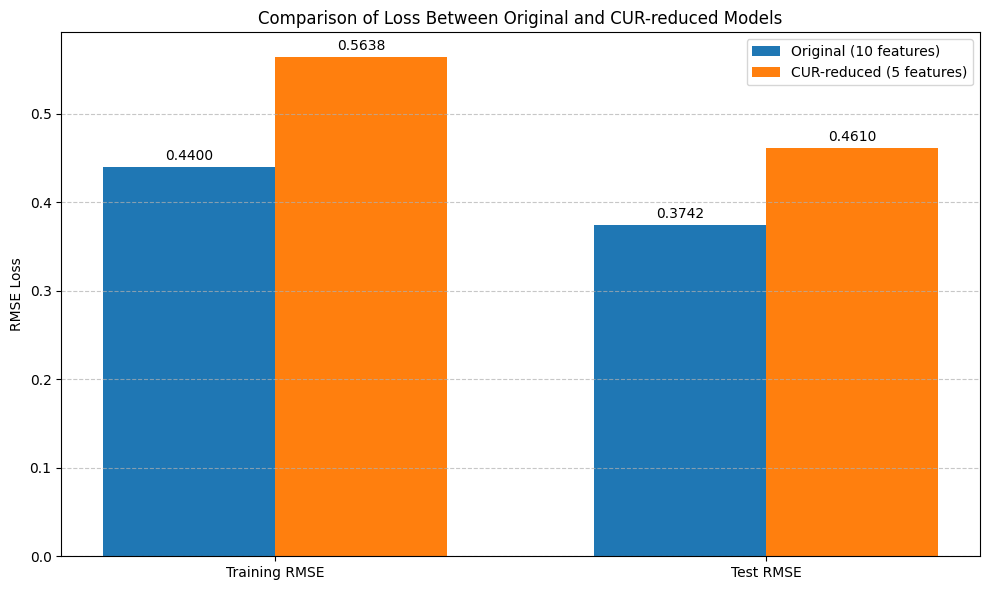


Total runtime: 37.80 seconds


In [ ]:
def main():
    try:
        start_time = time.time()

        #Load and preprocess data
        print("\nLoading and preprocessing data...")
        df = load_and_preprocess_data("gold_prices.csv")
        print("Dataset sample:")
        df.show(5)

        #Define feature columns
        feature_cols = [f"lag_{i}" for i in range(1, 11)]

        #Create feature vector for original data
        print("\nCreating feature vectors...")
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        vector_df = assembler.transform(df).select(
            "Date", "features", col("Sell Price").alias("label"), *feature_cols)

        #Cache dataframe for performance
        vector_df.cache()

        #Split data into training and test sets
        print("\nSplitting data...")
        train_data, test_data = vector_df.randomSplit([0.7, 0.3], seed=42)
        print(f"Training set size: {train_data.count()}")
        print(f"Test set size: {test_data.count()}")

        #Train and evaluate original model
        print("\n=== Original Model (10 features) ===")
        original_metrics = train_and_evaluate_model(
            train_data, test_data, "features", "label", "Original Model")

        #Apply CUR decomposition
        print("\n=== Applying CUR Decomposition ===")
        cur = CUR_Decomposition(target_dim=5, seed=42)
        cur.fit(vector_df)

        #Transform data using CUR
        print("\nTransforming data with CUR...")
        cur_train_data = cur.transform(train_data)
        cur_test_data = cur.transform(test_data)

        #Show sample of transformed data
        print("\nSample of CUR-transformed data:")
        cur_train_data.select("features_cur").show(2, truncate=False)

        #Train and evaluate CUR-reduced model
        print("\n=== CUR-Reduced Model (5 features) ===")
        cur_metrics = train_and_evaluate_model(
            cur_train_data, cur_test_data, "features_cur", "label", "CUR-reduced Model")

        #Create comparison visualization
        print("\nCreating comparison visualization...")
        create_comparison_visualization(original_metrics, cur_metrics)

        #Print overall runtime
        total_time = time.time() - start_time
        print(f"\nTotal runtime: {total_time:.2f} seconds")

    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()
    finally:
        if 'vector_df' in locals():
            vector_df.unpersist()
        spark.stop()

if __name__ == "__main__":
    main()